In [5]:
#80% of emails are for training 20% for testing good trainign set is balanced
#equal number of spam and not spam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
data_spam = pd.read_csv('spam-apache.csv', header=0)
rows = data_spam.iloc[:, 0:2]
shuffle = np.random.permutation(np.shape(rows)[0])

rows = rows.iloc[shuffle]
training_size = int(len(rows) * .8)
training_set = rows[:training_size]
test_set = rows[training_size:]

In [6]:
def cleanup(email):
  ignore = ['i','me','my','myself','we','our','ours','ourselves','you',"you're",
   "you've","you'll",'your','he','him','his','himself','she','her',
   'hers','herself','it',"it's",'its','itself','they','them','their','theirs',
   'what','which','who','this','that',"that'll",'these','those','am',
   'is','are','was','were','be','been','being','have','has','had','having',
   'do','does','did','doing','a','an','the','and','but','if','or','because',
   'as','until','while','of','at','by','for','with','about','against',
   'during','before','after','to','from','again','here','there', 'on',
   'when','where','why','how','all','any','no','only','own','same','too',
   'very','can','will','just','now',"didn't","haven't","isn't","wasn't",'·','', '>']
  
  words = re.sub("[^\w]", " ",  email).split()
  cleaned = []
  for word in words:
    if word.lower() not in ignore:
      cleaned.append(word.lower())
      
  #cleaned = [w.lower() for w in words if w.lower() not in ignore]
  return cleaned


In [7]:
allWords ={}
# splits dataset the first 80% into training and the rest into test

e = [training_set.iloc[:, 0], training_set.iloc[:, 1]]

# cleans up the training set and 
# adds words and occurences to ham/spam dictionaries

#gets a list of all words
for i in range(len(training_set)):
  email = e[1].iloc[i]
  words = cleanup(email)
  for word in words:
    if(word not in allWords):
      allWords[word] = 1
    else:
      allWords[word] += 1

#puts all words with occurences over 10 in vocab
vocab = {}
word_occurences = 0
for word in allWords:
  if (allWords[word] >= word_occurences):
    vocab[word] = 0



In [8]:
#counts the words for ham and spam
ham = vocab.copy()
spam = vocab.copy()
count_spam = 0
for i in range(len(training_set)):
  email = e[1].iloc[i]
  words = cleanup(email)
  if(e[0].iloc[i] == -1):#spam
    count_spam += 1
    for word in words:
      if(word in vocab):
        if(word in spam):
          spam[word] += 1
        else:
          spam[word] = 1
  else: #ham
    for word in words:
      if(word in vocab):
        if(word in ham):
          ham[word] += 1
        else:
          ham[word] = 1

count_ham = training_size - count_spam
# count_ham = sum(ham.values())
# count_spam = sum(spam.values())


count_all = count_ham + count_spam
print(len(ham))
print(count_ham, count_spam, count_all)

6217
97 102 199


In [9]:
# initializes a class dictionary and holds two seperate dictionaries of 
# probabilities of ham or spam for each word which are the features
features = {}
features['ham'] = {}
features['spam'] ={}

#populates the dictionaries
for word, count in ham.items():
  features['ham'][word] = np.log((int(count) + 1) / (count_ham + count_all))
for word, count in spam.items():
  features['spam'][word] = np.log((int(count) + 1) / (count_spam + count_all))

val_spam_pre = np.log(count_spam / count_all)
val_ham_pre  = np.log(count_ham / count_all)
smooth_ham  = np.log(1/count_ham + count_all)
smooth_spam = np.log(1/count_spam + count_all)



In [10]:
# Testing
e_test = [test_set.iloc[:, 0], test_set.iloc[:, 1]]
result = np.array([])
gt = np.array(e_test[0])
def test(words):
  val_spam = val_spam_pre
  val_ham  = val_ham_pre
  for feature in features:
    if feature == 'ham':
      for word in words:
        if word in features[feature]:
          val_ham += features[feature][word]
        else:
          val_ham += smooth_ham
    else:
      for word in words:
        if word in features[feature]:
          val_spam += features[feature][word]
        else:
          val_spam += smooth_spam
  if( val_ham >= val_spam ):
    result = 1
  else:
    result = -1
  return result

for i in range(len(test_set)):
  email = e_test[1].iloc[i]
  words = cleanup(email)
  # print('Ground Truth: ', e_test[0].iloc[i])
  result = np.append(result, test(words))
print(len(gt))
print(len(result))



50
50


Confusion Matrix:
[[0.54 0.02]
 [0.02 0.42]]
Accuracy:  96.0 %


<Figure size 720x720 with 0 Axes>

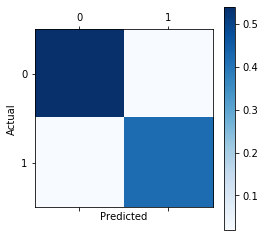

In [11]:
# Confusion Matrix


cm = np.zeros((2, 2))
for i, x in zip(gt, result):
  if (i == 1 and x == 1):
    cm[0][0] += 1
  elif(i == -1 and x == -1):
    cm[1][1] += 1
  elif(i == -1 and x == 1):
    cm[1][0] += 1
  elif(i == 1 and x == -1):
    cm[0][1] += 1
cm[0][0] = cm[0][0]/len(result)
cm[0][1] = cm[0][1]/len(result)
cm[1][0] = cm[1][0]/len(result)
cm[1][1] = cm[1][1]/len(result)

accuracy = float(cm[0][0] + cm[1][1]) * 100
print('Confusion Matrix:')
print(cm)
print('Accuracy: ',accuracy, '%')

plt.figure(figsize=(10,10))
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Confusion_matrix.jpg')

